Connected to base (Python 3.12.3)

In [2]:
# 0. Import Library
# =============================
import pandas as pd
import numpy as np
import nlpaug.augmenter.word as naw
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalAveragePooling1D, Bidirectional, LSTM, Dropout, Dense, concatenate

In [3]:
df_train = pd.read_excel('../data/output/df_train.xlsx', sheet_name='Sheet1')
df_test = pd.read_excel('../data/output/df_test.xlsx', sheet_name='Sheet1')
le = LabelEncoder()
df_train['Encoded_Label_Valid'] = le.fit_transform(df_train['Validasi Sentimen'])
df_test['Encoded_Label'] = le.transform(df_test['Sentimen'])

c:\Users\atrke\miniconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
# 3. Handle Imbalanced Data
# =============================
df_neg = df_train[df_train['Validasi Sentimen'] == 'negative'].copy()
aug = naw.SynonymAug(aug_src='wordnet')
df_neg['Augmented_Text'] = df_neg['Text Normalization'].apply(lambda x: aug.augment(x))
df_neg_augmented = df_neg.copy()
df_neg_augmented['Text Normalization'] = df_neg_augmented['Augmented_Text']
df_neg_final = pd.concat([df_neg, df_neg_augmented], ignore_index=True)

df_other = df_train[df_train['Validasi Sentimen'] != 'negative']
df_aug_combined = pd.concat([df_other, df_neg_final], ignore_index=True)

max_count = df_aug_combined['Encoded_Label_Valid'].value_counts().max()
df_balanced = pd.concat([
    resample(sub_df, replace=True, n_samples=max_count, random_state=42)
    for _, sub_df in df_aug_combined.groupby('Encoded_Label_Valid')
], ignore_index=True)


In [5]:
# 4. Tokenization
# =============================
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_balanced['Text Normalization'])

X_train = pad_sequences(tokenizer.texts_to_sequences(df_balanced['Text Normalization']),
                        maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y_train = df_balanced['Encoded_Label'].values

X_test = pad_sequences(tokenizer.texts_to_sequences(df_test['Text Normalization']),
                       maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y_test = df_test['Encoded_Label'].values

In [6]:
# 5. Load GloVe Embedding
# =============================
embedding_index = {}
with open("../src/glove/glove.6B.300d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

In [7]:
def build_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,)) # Hasil Tokenisasi

    embedding = Embedding(input_dim=len(word_index)+1, # Mengubah kata menjadi vector embed berdimensi tetap
                          output_dim=embedding_dim, # outputnya berupa dimensi
                          weights=[embedding_matrix],
                          input_length=MAX_SEQUENCE_LENGTH,
                          trainable=True)(input_layer) # Embedding diperbolehkan untuk menyesuaikan selama training
    # CNN Layer
    cnn = Conv1D(64, 7, activation='relu')(embedding) # Mendeteksi fitur lokal dengan 7 frasa, mengekstrak 128 jenis fitur, ReLU mengaktifkan sinyal positif
    
    # LSTM Layer
    # input: Hasil CNN yang masih berformat sekuens (3D tensor)
    lstm = Bidirectional(LSTM(128))(cnn) # Memahamai urutan kata 2 arah (maju-mundur). Hidden unit: 64 masing-masing arah
    x = Dropout(0.2)(lstm) # Dropout untuk mengurangi overfitting
    x = Dense(64, activation='relu')(x) # Fully connected layer dengan 64 neuron, ReLU sebagai aktivasi
    output = Dense(3, activation='softmax')(x) # Output layer dengan 3 neuron (jumlah kelas), softmax untuk probabilitas kelas
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [8]:
# 9. 5-Fold Cross Validation on Balanced Train Data
# ============================================================================
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accs, precisions, recalls, f1s, losses = [], [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"\nFold {fold}/10")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = build_model()
    model.fit(X_tr, y_tr, epochs=10, batch_size=32, verbose=0)

    y_pred_proba = model.predict(X_val)
    y_pred = y_pred_proba.argmax(axis=1)

    accs.append(accuracy_score(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred, average='macro'))
    recalls.append(recall_score(y_val, y_pred, average='macro'))
    f1s.append(f1_score(y_val, y_pred, average='macro'))
    losses.append(log_loss(y_val, y_pred_proba))

# Summary
print("\n===== 10-Fold CV Results on Balanced Training Data =====")
print("Average Accuracy: {:.2f}%".format(np.mean(accs) * 100))
print("Average Precision: {:.2f}%".format(np.mean(precisions) * 100))
print("Average Recall: {:.2f}%".format(np.mean(recalls) * 100))
print("Average F1-Score: {:.2f}%".format(np.mean(f1s) * 100))
print("Average Log Loss: {:.2f}".format(np.mean(losses)))


Fold 1/10


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

Fold 2/10


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step

Fold 3/10


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step

Fold 4/10


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step

Fold 5/10


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step

Fold 6/10


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step

Fold 7/10


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step

Fold 8/10


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

Fold 9/10


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step

Fold 10/10


C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step

===== 10-Fold CV Results on Balanced Training Data =====
Average Accuracy: 93.21%
Average Precision: 91.25%
Average Recall: 90.39%
Average F1-Score: 90.74%
Average Log Loss: 0.45


In [11]:
import pickle

# 8. Save the Trained Model
# =============================
model.save('../models/sentiment_model.h5')
print("Model saved to '../models/sentiment_model.h5'")

# Also save the tokenizer for future use
with open('../models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved to '../models/tokenizer.pkl'")

# Save the label encoder
with open('../models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Label encoder saved to '../models/label_encoder.pkl'")

Model saved to '../models/sentiment_model.h5'
Tokenizer saved to '../models/tokenizer.pkl'
Label encoder saved to '../models/label_encoder.pkl'


In [9]:
# 10. Final Training on Full Train Set & Evaluation on Test Set
# =============================

# Train Final Model on Balanced Training Set
model = build_model()
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict on Test Set
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

# Decode label integer back to original class
y_true_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

from sklearn.metrics import classification_report

print("Classification Report (Test Set):\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

C:\Users\atrke\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.6182 - loss: 0.8703
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8153 - loss: 0.4675
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9410 - loss: 0.1718
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9735 - loss: 0.0850
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9883 - loss: 0.0367
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9961 - loss: 0.0139
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9979 - loss: 0.0094
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9974 - loss: 0.0047
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9965 - loss: 0.0139
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9988 - loss: 0.0072
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Classification Report (Test Set):

              precision    recall  f1-score   support

    negative      

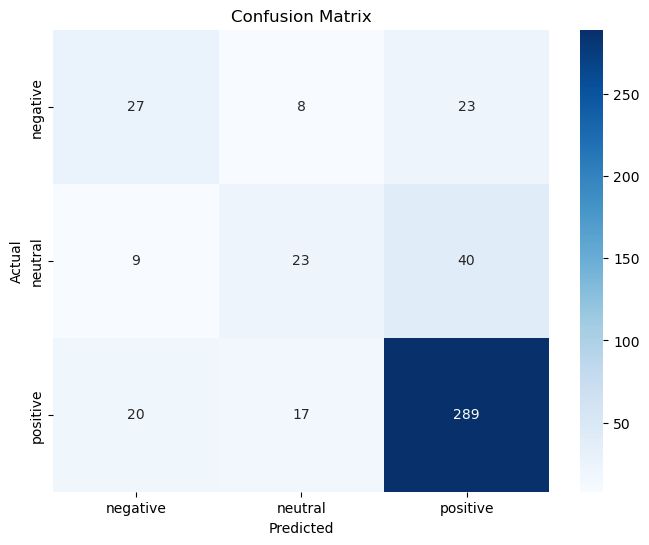

Confusion Matrix:
Predicted ->
Actual ↓
  negative        27         8        23
   neutral         9        23        40
  positive        20        17       289


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print confusion matrix with labels
print("Confusion Matrix:")
print("Predicted ->")
print("Actual ↓")
for i, true_label in enumerate(le.classes_):
    print(f"{true_label:>10}", end="")
    for j, pred_label in enumerate(le.classes_):
        print(f"{cm[i][j]:>10}", end="")
    print()

No kernel connected